In [1]:
import pandas as pd

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(1)

In [2]:
# read data
df = pd.read_csv('data/Strategic_Subject_List_-_Historical.csv')
df.head()

/tmp/ipykernel_697/152499078.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/Strategic_Subject_List_-_Historical.csv')


,SSL SCORE,PREDICTOR RAT AGE AT LATEST ARREST,PREDICTOR RAT VICTIM SHOOTING INCIDENTS,PREDICTOR RAT VICTIM BATTERY OR ASSAULT,PREDICTOR RAT ARRESTS VIOLENT OFFENSES,PREDICTOR RAT GANG AFFILIATION,PREDICTOR RAT NARCOTIC ARRESTS,PREDICTOR RAT TREND IN CRIMINAL ACTIVITY,PREDICTOR RAT UUW ARRESTS,SEX CODE CD,...,RAW_HEAT_SCORE,STATUS I,PRE RAW HEAT SCORE,TRAP FLAGS,SSL FLAGS,LATITUDE,LONGITUDE,CENSUS TRACT,COMMUNITY AREA,LOCATION
0,306,20-30,0,0,0,0,0,-0.3,0,M,...,0.09110,Y,9110,NaN,NaN,NaN,NaN,NaN,,NaN
1,352,20-30,0,1,0,0,0,0.0,0,M,...,0.09949,Y,9949,NaN,NaN,NaN,NaN,NaN,,NaN
2,349,20-30,0,0,2,0,2,0.0,0,M,...,0.09908,Y,9908,NaN,NaN,NaN,NaN,NaN,,NaN
3,344,20-30,0,0,3,0,0,-0.3,0,M,...,0.09810,Y,9810,NaN,NaN,NaN,NaN,NaN,,NaN
4,343,20-30,0,0,1,0,0,0.4,0,M,...,0.09794,Y,9794,NaN,NaN,NaN,NaN,NaN,,NaN


In [3]:
# drop unnecessary columns
df.drop(['MAJORITY DIST', 'DLST', 'IDOC RES CITY', 'IDOC RES STATE CODE', 'IDOC RES ZIP CODE', 'IDOC CPD DIST', 'TRAP FLAGS', 'SSL FLAGS'], axis=1, inplace = True) #IDOC RES CITY (typos), 
df.drop(['STOP ORDER NO', 'TRAP STATUS', 'LATEST WEAPON ARR DATE', 'LATEST NARCOTIC ARR DATE', 'LATEST DOMESTIC ARR DATE', 'SSL LAST PTV DATE', 'TRAP STATUS', 'LATITUDE', 'LONGITUDE', 'CENSUS TRACT', 'LOCATION'], axis=1, inplace = True) #probably still want to include

# fill and/or remove na values
df["PAROLEE I"].fillna("N", inplace = True)
df["WEAPONS ARR CNT"].fillna("0", inplace = True)
df["NARCOTICS ARR CNT"].fillna("0", inplace = True)
df["DOMESTIC ARR CNT"].fillna("0", inplace = True)
df.dropna(how='any', axis = 0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398684 entries, 0 to 398683
Data columns (total 30 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   SSL SCORE                                 398684 non-null  int64  
 1   PREDICTOR RAT AGE AT LATEST ARREST        398582 non-null  object 
 2   PREDICTOR RAT VICTIM SHOOTING INCIDENTS   398684 non-null  int64  
 3   PREDICTOR RAT VICTIM BATTERY OR ASSAULT   398684 non-null  int64  
 4   PREDICTOR RAT ARRESTS VIOLENT OFFENSES    398684 non-null  int64  
 5   PREDICTOR RAT GANG AFFILIATION            398684 non-null  int64  
 6   PREDICTOR RAT NARCOTIC ARRESTS            398684 non-null  int64  
 7   PREDICTOR RAT TREND IN CRIMINAL ACTIVITY  398684 non-null  float64
 8   PREDICTOR RAT UUW ARRESTS                 398684 non-null  int64  
 9   SEX CODE CD                               398684 non-null  object 
 10  RACE CODE CD        

In [4]:
df['SSL SCORE'] = np.where(df['SSL SCORE']<250 , 0, df['SSL SCORE']) # high risk = 1, low risk = 0
df['SSL SCORE'] = np.where(df['SSL SCORE']>=250 , 1, df['SSL SCORE'])
df['SSL SCORE'] = df['SSL SCORE'].astype(str)
my_dict = {'0':'Low', '1':'High'}
df = df.replace({'SSL SCORE':my_dict})
df

,SSL SCORE,PREDICTOR RAT AGE AT LATEST ARREST,PREDICTOR RAT VICTIM SHOOTING INCIDENTS,PREDICTOR RAT VICTIM BATTERY OR ASSAULT,PREDICTOR RAT ARRESTS VIOLENT OFFENSES,PREDICTOR RAT GANG AFFILIATION,PREDICTOR RAT NARCOTIC ARRESTS,PREDICTOR RAT TREND IN CRIMINAL ACTIVITY,PREDICTOR RAT UUW ARRESTS,SEX CODE CD,...,NARCOTICS ARR CNT,CPD ARREST I,DOMESTIC ARR CNT,AGE CURR,RAW SSL SCORE,HEAT SCORE,RAW_HEAT_SCORE,STATUS I,PRE RAW HEAT SCORE,COMMUNITY AREA
0,High,20-30,0,0,0,0,0,-0.3,0,M,...,0,N,0,20-30,0.09110,306,0.09110,Y,9110,
1,High,20-30,0,1,0,0,0,0.0,0,M,...,0,N,0,20-30,0.09949,352,0.09949,Y,9949,
2,High,20-30,0,0,2,0,2,0.0,0,M,...,0,N,0,20-30,0.09908,349,0.09908,Y,9908,
3,High,20-30,0,0,3,0,0,-0.3,0,M,...,0,N,0,20-30,0.09810,344,0.09810,Y,9810,
4,High,20-30,0,0,1,0,0,0.4,0,M,...,0,N,0,20-30,0.09794,343,0.09794,Y,9794,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398679,Low,50-60,0,0,0,0,0,0.3,0,F,...,0,Y,0,50-60,0.06845,183,0.06845,Y,6845,NEW CITY
398680,Low,60-70,0,0,2,0,0,2.2,0,M,...,0,Y,0,60-70,0.07396,213,0.07396,Y,7396,OHARE
398681,High,30-40,0,0,0,0,0,-0.3,0,M,...,0,Y,0,30-40,0.08569,277,0.08569,Y,8569,NEW CITY
398682,Low,40-50,0,0,0,0,0,-0.3,0,F,...,0,Y,0,40-50,0.07535,220,0.07535,Y,7535,GARFIELD RIDGE


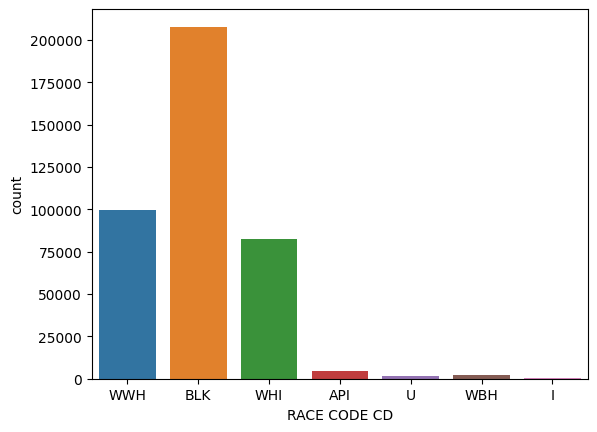

In [5]:
sns.countplot(x ='RACE CODE CD', data = df)
plt.show()

/tmp/ipykernel_697/2832013552.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['White Hispanic', 'Black', 'White', 'Asian / Pacific Islander', 'Unknown', 'Black Hispanic', 'American Indian / Alaskan Native'], rotation = 90)


[Text(0, 0, 'White Hispanic'),
 Text(1, 0, 'Black'),
 Text(2, 0, 'White'),
 Text(3, 0, 'Asian / Pacific Islander'),
 Text(4, 0, 'Unknown'),
 Text(5, 0, 'Black Hispanic'),
 Text(6, 0, 'American Indian / Alaskan Native')]

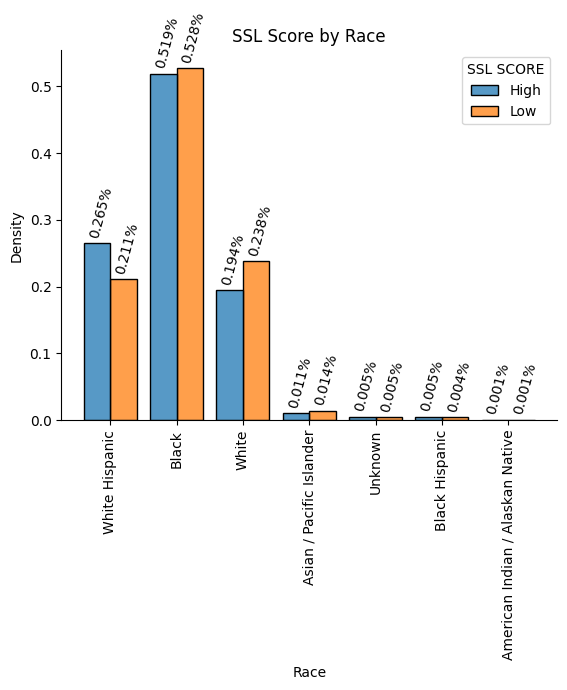

In [17]:
ax = sns.histplot(x = df['RACE CODE CD'], hue=df['SSL SCORE'], multiple="dodge", stat='density', shrink=0.8, common_norm=False)
ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
for p in ax.patches:
    ax.annotate('{:.3f}%'.format(p.get_height()), (p.get_x()+.05, p.get_height()+0.01), rotation = 75)
ax.set_xlabel('Race')
ax.set_title('SSL Score by Race')
ax.set_xticklabels(['White Hispanic', 'Black', 'White', 'Asian / Pacific Islander', 'Unknown', 'Black Hispanic', 'American Indian / Alaskan Native'], rotation = 90)

In [7]:
print(.211+.528+.238+.014+.005+.004+.001)

1.001


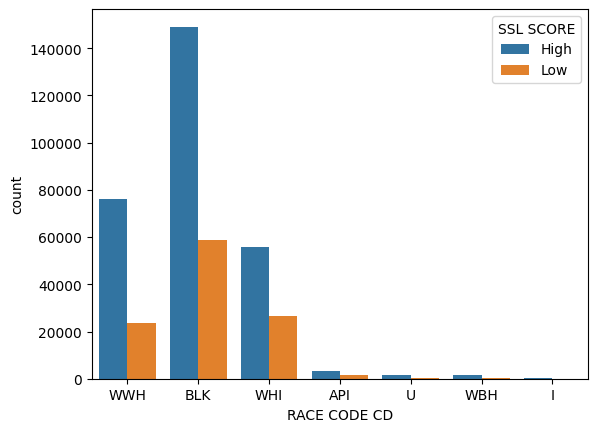

In [8]:
sns.countplot(x ='RACE CODE CD', hue = "SSL SCORE", data = df)
plt.show()

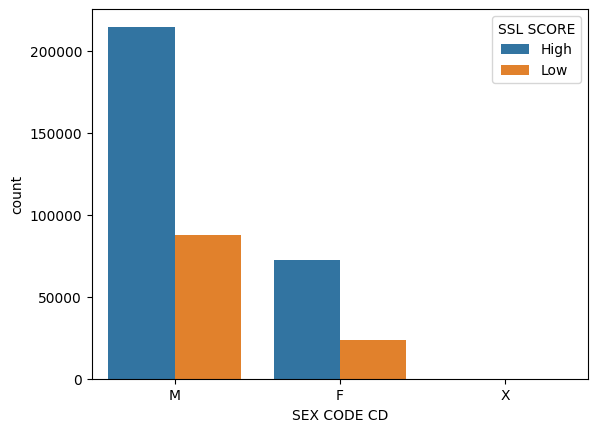

In [9]:
sns.countplot(x ='SEX CODE CD', hue = "SSL SCORE", data = df)
plt.show()

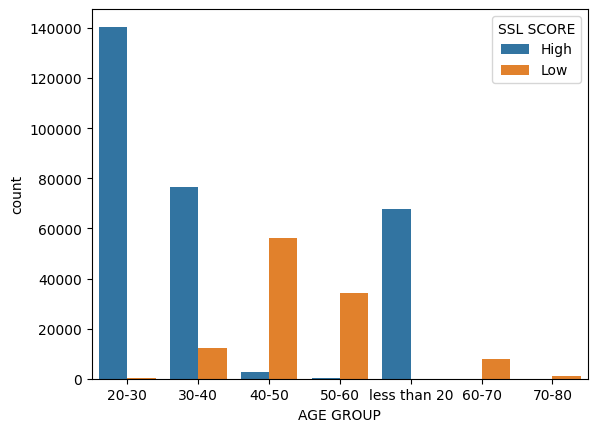

In [10]:
sns.countplot(x ='AGE GROUP', hue = "SSL SCORE", data = df)
plt.show()

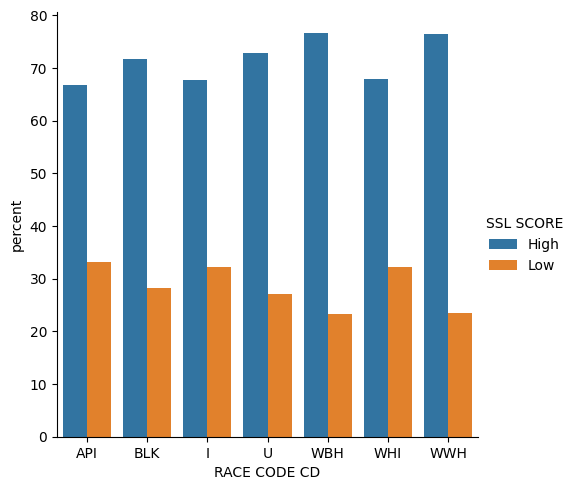

In [11]:
x,y = 'RACE CODE CD', 'SSL SCORE'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

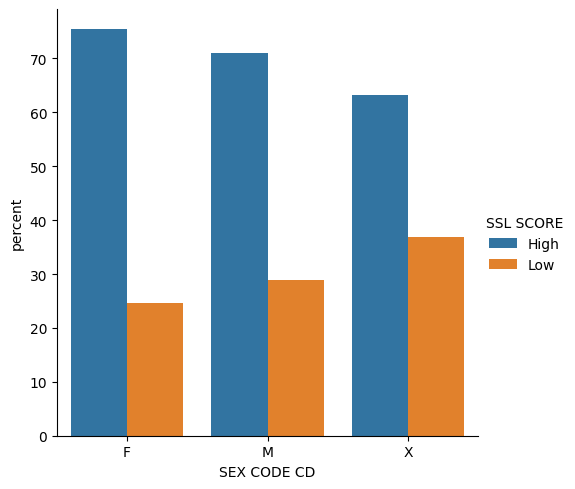

In [12]:
x,y = 'SEX CODE CD', 'SSL SCORE'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

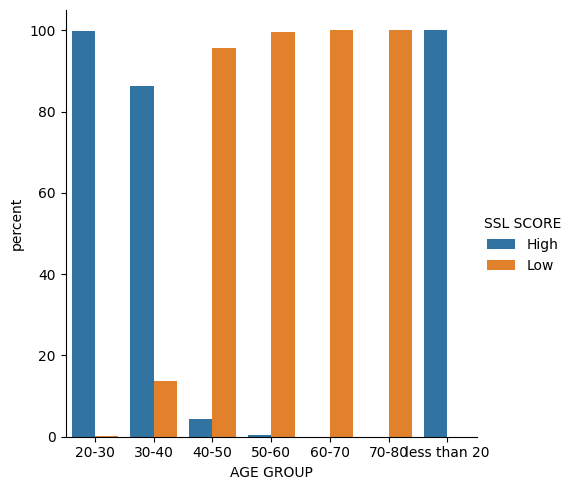

In [13]:
x,y = 'AGE GROUP', 'SSL SCORE'

(df
.groupby(x)[y]
.value_counts(normalize=True)
.mul(100)
.rename('percent')
.reset_index()
.pipe((sns.catplot,'data'), x=x,y='percent',hue=y,kind='bar'))

In [14]:
df.to_csv('data/preprocessed_data.csv', index=False)